In [1]:
from copy import deepcopy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score,\
                            recall_score, roc_auc_score, roc_curve, cohen_kappa_score, fbeta_score

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression, PLSCanonical                       
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression

from StratifiedGroupKFold import StratifiedGroupKFold as SGKF

import catboost
from catboost import *

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
samples = pd.read_excel(u'20.01.23 список образцов Моча.xlsx', header=2)
samples.dropna(subset=['Gender'], inplace=True)

samples.fillna(0, inplace=True)
samples.reset_index(drop=True, inplace=True)

In [7]:
spectra1 = pd.read_csv('urine_chm001-250.csv')
spectra2 = pd.read_csv('urine_chm251-500.csv')
spectra_init = pd.concat([spectra1, spectra2],  ignore_index=True)

spectra = spectra_init.filter(regex='^Ch')

mmscaler = MinMaxScaler(feature_range=(-1,1))
spectra = pd.DataFrame(mmscaler.fit_transform(spectra.T).T)
del(spectra1, spectra2)

frame_lol = samples[['Gender','Age','Dataset']+list(samples.filter(regex=r'_a$').columns)]
spectra['Dataset'] = spectra_init['Dataset']
spectra = pd.merge(left=spectra, right=frame_lol, how='left', on='Dataset')
spectra.dropna(subset=samples.filter(regex=r'_a$').columns, inplace=True)
spectra = pd.DataFrame(spectra.values, columns=spectra.columns)

In [10]:
plt.style.use('seaborn')
plt.figure(figsize=(10,7))
for N1 in range(0,spectra.shape[0],5):

    X = range(1,19)
    y1 = spectra.iloc[N1,0:36:2].values
    y2 = spectra.iloc[N1, 1:37:2].values
    f1 = interp1d(X, y1, kind='cubic')
    f2 = interp1d(X, y2, kind='cubic')

    X_new = np.linspace(1,18,200)
    
    plt.scatter(X ,y1, c='r', s=50)
    plt.plot(X_new, f1(X_new), c='r')

    plt.scatter(X ,y2, c='b', s=50)
    plt.plot(X_new, f2(X_new), c='b')

    plt.xticks(range(1,19))


#     plt.savefig('Typical_Urine_Spectra.pdf')

NameError: name 'interp1d' is not defined

<Figure size 720x504 with 0 Axes>

In [48]:
from sklearn.model_selection import StratifiedKFold

In [52]:

@interact
def to_show(selected_target = ['Density_a', 'pH_a', 'Protein_a',
                               'Glucose_a', 'Ketones_a', 'Leukocyte_a', 'Nitrite_a',
                               'Urobilinogen_a', 'Blood_a', 'Erythrocyte_a',
                               'Squamous cells_a', 'Hyaline cylinders_a', 'Bacteria_a',
                               'Crystals_a', 'Ferment_a', 'Small cells_a', 'Pathological cylinders_a',
                               'Slime_a', 'Spermatozoon_a']):
    
    X = spectra.iloc[:,:36]
    ad_feat = spectra.iloc[:,37:39]
    y = spectra[selected_target].astype(float)
    groups = spectra.Dataset.values
    
#     LDA = LinearDiscriminantAnalysis(n_components=1)
#     LDA_spectra = pd.DataFrame(LDA.fit_transform(X.drop(['Dataset','Gender','Age'], axis=1), y))
#     LDA_spectra = pd.concat([LDA_spectra, X.loc[:,['Dataset','Gender','Age']]\
#                              .reindex(index=range(spectra.shape[0]))],axis=1)
#     LDA_spectra['target'] = y.values
#     LDA_spectra.dropna(inplace=True)
#     groups = LDA_spectra.Dataset.values
#     LDA_spectra.drop('Dataset', axis=1, inplace=True)

#     LDA_X = LDA_spectra.drop('target', axis=1)
#     LDA_y = LDA_spectra.target
    
    skf = StratifiedKFold(5)

    # counter
    cntr = 0
    plt_flag = False

    for train_indicies, test_indicies in skf.split(X, y):
        cntr+=1
        if cntr == 5: plt_flag = True   


        Train_X, Test_X = X.iloc[train_indicies, :], X.iloc[test_indicies, :]
        Train_y , Test_y = y.iloc[train_indicies], y.iloc[test_indicies]
        Train_ADD_Features, Test_ADD_Features = ad_feat.iloc[train_indicies, :], ad_feat.iloc[test_indicies, :]

        lda_model = LinearDiscriminantAnalysis().fit(Train_X, Train_y)
        LDA_Train_X, LDA_Test_X = lda_model.transform(Train_X), \
                                  lda_model.transform(Test_X)

        Train_Emb = pd.DataFrame(np.concatenate([LDA_Train_X, Train_ADD_Features], axis=1), 
                                 columns=['lda', 'Gender', 'Age'])
        Test_Emb = pd.DataFrame(np.concatenate([LDA_Test_X, Test_ADD_Features], axis=1),
                                columns=['lda', 'Gender', 'Age'])
        
#         # initialize Pool
#         train_pool = Pool(Train_X, Train_y, cat_features=['Gender'])
#         test_pool = Pool(Test_X, cat_features=[1]) 

        # specify the training parameters 
        model = CatBoostClassifier(
            loss_function='Logloss',
            iterations=200,
            random_seed=21,
            learning_rate=0.05,
            custom_loss=['AUC', 'Precision', 'Recall'],
            # eval_metric='Recall',
            use_best_model=True,
            early_stopping_rounds=20,
            class_weights=(0.1, 0.9)
        )
        model.fit(
            Train_Emb, Train_y,
            cat_features=['Gender'],
            eval_set=(Test_Emb, Test_y),
            verbose=False,
            plot=plt_flag
        )
        # make the prediction using the resulting model
        preds = model.predict(Test_Emb)
        print(classification_report(Test_y, preds))
        

interactive(children=(Dropdown(description='selected_target', options=('Density_a', 'pH_a', 'Protein_a', 'Gluc…

## CV for all Anomalies : threshold finding

In [55]:
from tqdm.notebook import tqdm
from itertools import product

In [65]:
def predict(clf, X, trsh):
    probs = clf.predict_proba(X)
    preds = list(map(lambda x: 1 if x>=trsh else 0, probs[:,1]))
    return preds

def metrics_ret(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cohen_kappa = cohen_kappa_score(y_true, y_pred)
    return np.array([acc, prec, rec, f1, cohen_kappa])

In [57]:
Anomaly_Cols = ['Density_a', 'pH_a', 'Protein_a',
               'Glucose_a', 'Ketones_a', 'Leukocyte_a', 'Nitrite_a',
               'Urobilinogen_a', 'Blood_a', 'Erythrocyte_a',
               'Squamous cells_a', 'Hyaline cylinders_a', 'Bacteria_a',
               'Crystals_a', 'Ferment_a', 'Small cells_a', 'Pathological cylinders_a',
               'Slime_a', 'Spermatozoon_a']

Metrics = ['Accuracy', 'Precision', 'Recall', 'F-Score', 'Cohen`s kappa', 'Norm/Anom']

Exam_results_df = pd.DataFrame(index=pd.MultiIndex.from_product([Anomaly_Cols,['CV', 'EXAM']]), columns=Metrics)

In [59]:
## Поиск порога

def max_metric(name, y_true, y_pred):
    if name=='precision':
        return precision_score(y_true, y_pred)
    elif name=='recall':
        return recall_score(y_true, y_pred)
    elif name=='f-score':
        return fbeta_score(y_true, y_pred, beta=1)
    elif name=='roc-auc':
        return roc_auc_score(y_true, y_pred)
    elif name=='cohen':
        return cohen_kappa_score(y_true, y_pred)
    

Best_trsh_regul_dict = {}


X = spectra.iloc[:,:36]
group = spectra.Dataset

for ANOMAL in tqdm(Anomaly_Cols):
    Metrics = dict()
    y = spectra[ANOMAL]

    
#     LDA = LinearDiscriminantAnalysis(n_components=1)
#     LDA_spectra = pd.DataFrame(LDA.fit_transform(X.drop(['Dataset','Gender','Age'], axis=1), y))
#     LDA_spectra = pd.concat([LDA_spectra, X.loc[:,['Dataset','Gender','Age']]\
#                              .reindex(index=range(spectra.shape[0]))],axis=1)
#     LDA_spectra['target'] = y.values
#     LDA_spectra.dropna(inplace=True)
#     Groups = LDA_spectra.Dataset.values
#     LDA_spectra.drop('Dataset', axis=1, inplace=True)

    LDA_X = LDA_spectra.drop('target', axis=1)
    LDA_y = LDA_spectra.target

    BEST_TRSH = 0.5

    for TRSH, LR in product(np.arange(0.05,1.0,0.05), [0.08, 0.1, 0.12]):
        temp_results = []
        
        for train_inds, test_inds in SGKF(LDA_X, LDA_y, Groups):
            Train_X, Train_y = LDA_X.iloc[train_inds,:], LDA_y.iloc[train_inds]
            Test_X, Test_y =  LDA_X.iloc[test_inds,:], LDA_y.iloc[test_inds]

            LDA = LinearDiscriminantAnalysis(n_components=1)
            LDA_model = LDA.fit(Train_X, Train_y)
            LDA_train = pd.DataFrame(LDA_model.transform(Train_X))
            LDA_train['target'] = Train_y.values
            LDA_test = pd.DataFrame(LDA_model.transform(Test_X))
            LDA_test['target'] = Test_y.values

            model = CatBoostClassifier(
            loss_function='Logloss',
            iterations=500,
            random_seed=21,
            learning_rate=LR,
            custom_loss=['AUC', 'Accuracy', 'Precision', 'Recall'],
            #eval_metric='AUC',
            use_best_model=True,
            early_stopping_rounds=20,
            class_weights=(0.05, 0.95)
            )
    
            model.fit(
                Train_X, Train_y,
                cat_features=['Gender'],
                eval_set=(Test_X, Test_y),
                verbose=False,
                plot=False
            )
            Preds = predict(model, Test_X, TRSH)
            temp_results.append(max_metric('f-score', Test_y, Preds))
            
        Metrics[np.mean(temp_results)] = (TRSH.round(2), LR)
    
    BEST_TRSH_LR = Metrics[max(Metrics)]
    Best_trsh_regul_dict[ANOMAL] = BEST_TRSH_LR

NameError: name 'LDA_spectra' is not defined

In [69]:
Best_trsh_regul_dict

{'Density_a': (0.9, 0.08),
 'pH_a': (0.45, 0.1),
 'Protein_a': (0.65, 0.12),
 'Glucose_a': (0.6, 0.1),
 'Ketones_a': (0.35, 0.12),
 'Leukocyte_a': (0.75, 0.08),
 'Nitrite_a': (0.75, 0.08),
 'Urobilinogen_a': (0.45, 0.12),
 'Blood_a': (0.6, 0.12),
 'Erythrocyte_a': (0.55, 0.12),
 'Squamous cells_a': (0.6, 0.12),
 'Hyaline cylinders_a': (0.55, 0.12),
 'Bacteria_a': (0.8, 0.1),
 'Crystals_a': (0.7, 0.08),
 'Ferment_a': (0.35, 0.1),
 'Small cells_a': (0.7, 0.12),
 'Pathological cylinders_a': (0.65, 0.08),
 'Slime_a': (0.6, 0.1),
 'Spermatozoon_a': (0.15, 0.12)}

## CV for all Anomalies : result table

In [70]:
Models_for_each_anomaly = dict()
LDA_for_each_anomaly = dict()
TOTAL_a_target = spectra.TOTAL_a

for selected_target in tqdm_notebook(Anomaly_Cols[:-1]):
    TrVal_Models = []
    BEST_TRSH = Best_trsh_regul_dict[selected_target][0]
    BEST_LR = Best_trsh_regul_dict[selected_target][1]

    X = spectra.iloc[:,:39]
    y = spectra[selected_target]

    LDA = LinearDiscriminantAnalysis(n_components=1)
    LDA_spectra = pd.DataFrame(LDA.fit_transform(X.drop(['Dataset','Gender','Age'], axis=1), y))
    LDA_spectra = pd.concat([LDA_spectra, X.loc[:,['Dataset','Gender','Age']]\
                             .reindex(index=range(spectra.shape[0]))],axis=1)
    LDA_spectra['target'] = y.values
    LDA_spectra.dropna(inplace=True)
    Groups = LDA_spectra.Dataset.values
    LDA_spectra.drop('Dataset', axis=1, inplace=True)

    LDA_X = LDA_spectra.drop('target', axis=1)
    LDA_y = LDA_spectra.target
    
    LDA_for_each_anomaly[selected_target] = LDA
    
    CV_Metrics = []
    EXAM_Metrics = []
    
    gkf = GroupKFold(3)
    
    #counter
    cntr, plt_flag = 0, False
    for trval_inds, exam_inds in gkf.split(LDA_X,LDA_y,Groups):
        cntr+=1
        if cntr==3: plt_flag = True
    
        TrVal_X, Exam_X = LDA_X.iloc[trval_inds,:], LDA_X.iloc[exam_inds,:]
        TrVal_y, Exam_y = LDA_y.iloc[trval_inds], LDA_y.iloc[exam_inds]
        TrVal_Groups = Groups[trval_inds]
        
        Metrics = []
        trval_gkf = GroupKFold(3)
        for train_inds, test_inds in trval_gkf.split(TrVal_X, TrVal_y, TrVal_Groups):
            
            Train_X, Test_X = LDA_X.iloc[train_inds,:-1], LDA_X.iloc[test_inds,:-1]
            Train_y, Test_y = LDA_y.iloc[train_inds], LDA_y.iloc[test_inds]
            
            model = CatBoostClassifier(
            loss_function='Logloss',
            iterations=5000,
            random_seed=21,
            learning_rate=BEST_LR,
            custom_loss=['AUC', 'Accuracy', 'Precision', 'Recall'],
            eval_metric='AUC',
            use_best_model=True,
            early_stopping_rounds=200,
            class_weights=(0.05, 0.95)
            )
            
            model.fit(
                Train_X, Train_y,
                cat_features=['Gender'],
                eval_set=(Test_X, Test_y),
                verbose=False,
                plot=False
            )
            
            TrVal_Models.append(model)
            
        
            Preds = predict(model, Test_X, BEST_TRSH)
            Probs = model.predict_proba(Test_X)
            Metrics.append(metrics_ret(Test_y, Preds, Probs[:,1]))
            fpr, tpr, _ = roc_curve(Test_y, Probs[:,1])
        
#         final_model = CatBoostClassifier(
#             loss_function='Logloss',
#             iterations=500,
#             random_seed=21,
#             learning_rate=0.08,
#             custom_loss=['AUC', 'Accuracy', 'Precision', 'Recall'],
# #             eval_metric='Recall',
#             use_best_model=True,
#             early_stopping_rounds=100,
#             class_weights=(0.01, 0.99)
#             )
        
#         final_model.fit(
#                 TrVal_X, TrVal_y,
#                 cat_features=['Gender'],
#                 eval_set=(Exam_X, Exam_y),
#                 verbose=False,
#                 plot=False
#                 )
        
        Models_for_each_anomaly[selected_target] = TrVal_Models
    
        Ex_Preds, Ex_Probs = [], []
        for model in TrVal_Models:
            Ex_Preds.append(predict(model, Exam_X, BEST_TRSH))
            Ex_Probs.append(model.predict_proba(Exam_X))
        
        Ex_Preds = np.max(Ex_Preds, axis=0)
        Ex_Probs = np.mean(Ex_Probs, axis=0)
        
        CV_Metrics.append(np.mean(Metrics, axis=0))
        EXAM_Metrics.append(metrics_ret(Exam_y, Ex_Preds, Ex_Probs[:,1]).round(3))
    
    Exam_results_df.loc[(selected_target, 'CV'),:-1] = list(map( lambda x: '+-'.join([str(x[0].round(3)), str(x[1].round(3))]), zip(np.mean(CV_Metrics, axis=0),np.std(CV_Metrics, axis=0)) ))
    Exam_results_df.loc[(selected_target, 'EXAM'),:-1] = list(map( lambda x: '+-'.join([str(x[0].round(3)), str(x[1].round(3))]), zip(np.mean(EXAM_Metrics, axis=0),np.std(EXAM_Metrics, axis=0)) ))
    Exam_results_df.loc[(selected_target, 'EXAM'),'Norm/Anom'] = '/'.join([str(int(Exam_y.shape[0]-Exam_y.sum())), str(int(Exam_y.sum()))])



In [41]:
plt.style.use('default')

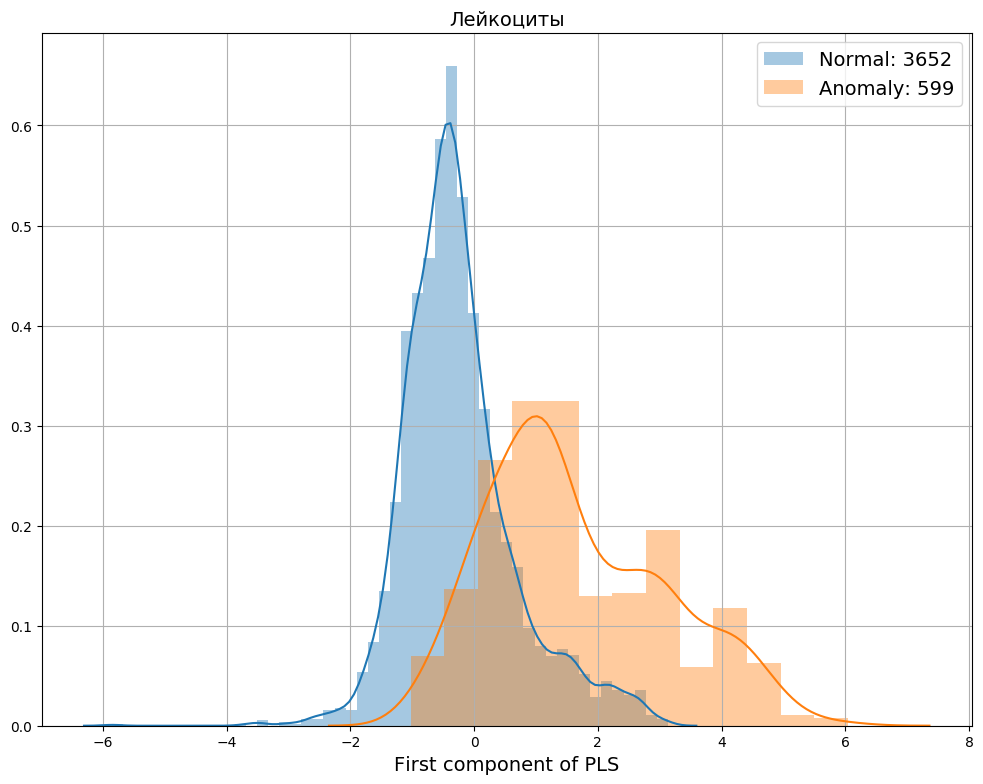

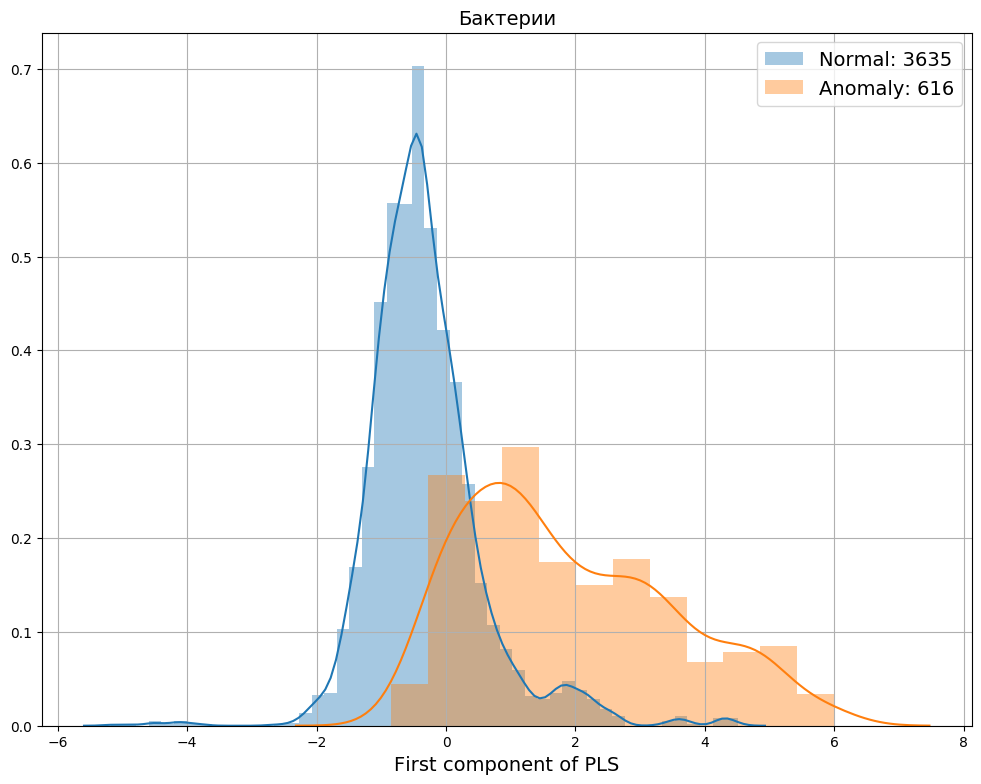

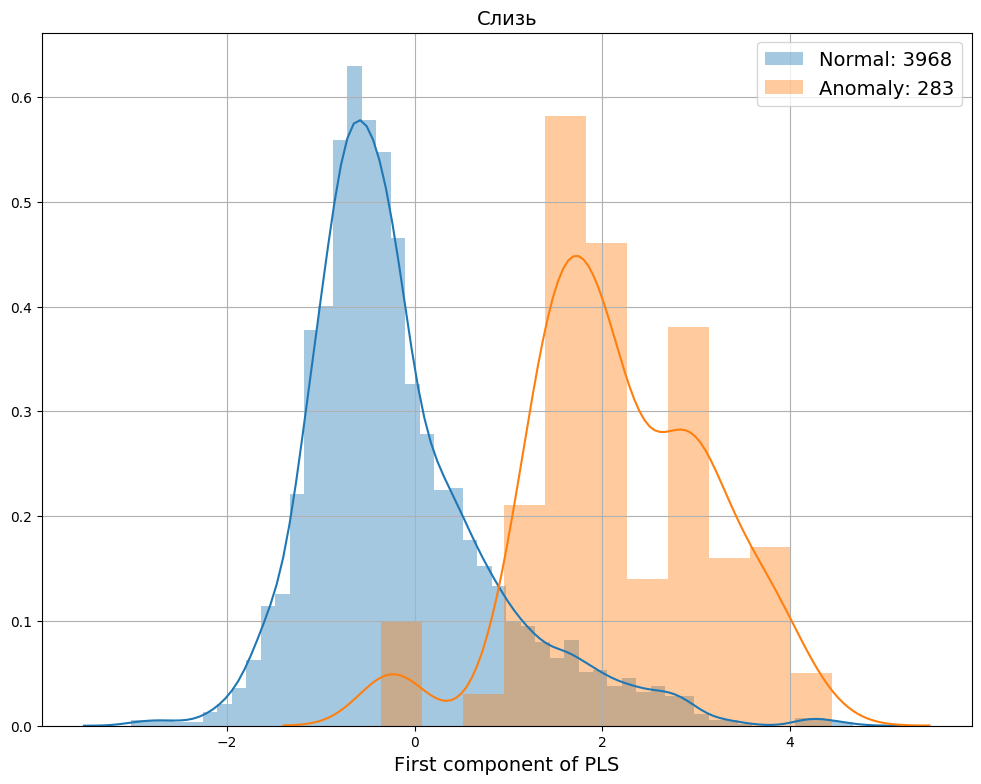

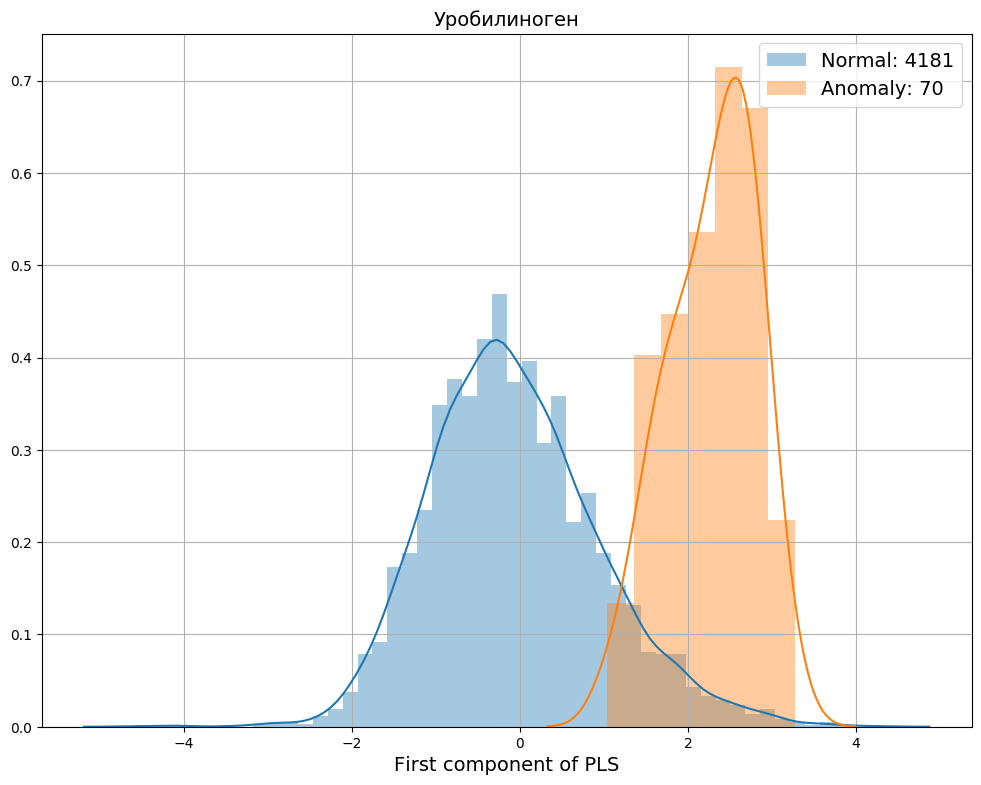

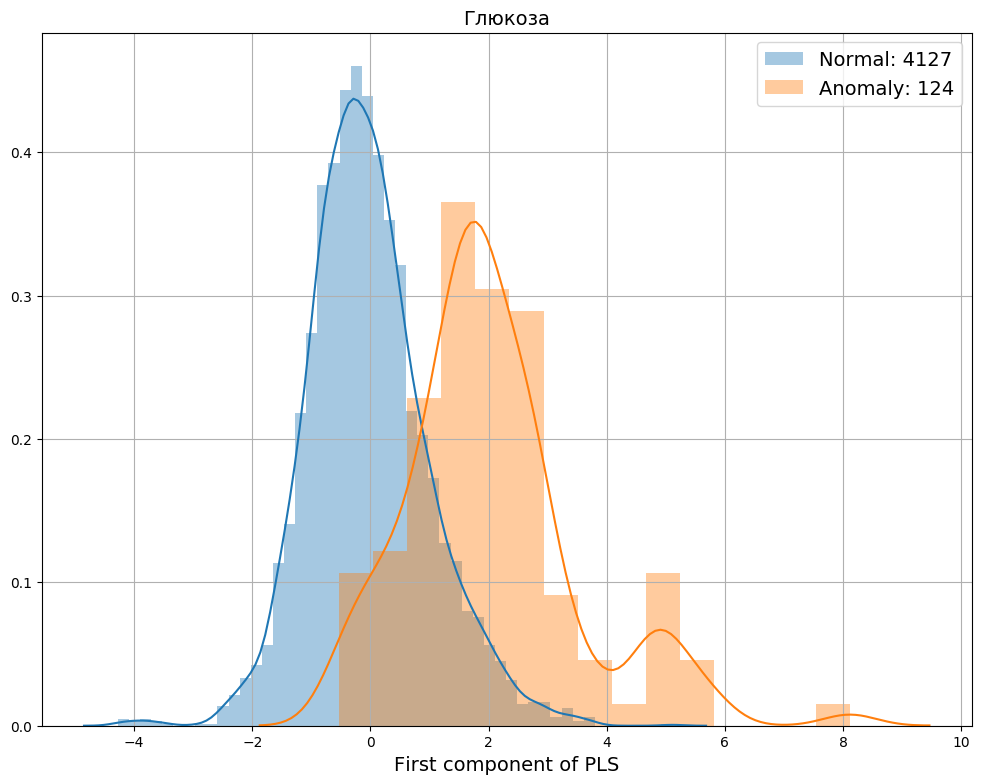

In [42]:
for Selected_Anomaly, Name in zip(['Leukocyte_a', 'Bacteria_a', 'Slime_a', 'Urobilinogen_a', 'Glucose_a'],
                                  ["Лейкоциты", "Бактерии", "Слизь", "Уробилиноген", "Глюкоза"]):

    X = spectra.iloc[:,:39]
    y = spectra[Selected_Anomaly]

    LDA = LinearDiscriminantAnalysis(n_components=1)
    LDA_spectra = pd.DataFrame(LDA.fit_transform(X.drop(['Dataset','Gender','Age'], axis=1), y))
    LDA_spectra = pd.concat([LDA_spectra, X.loc[:,['Dataset','Gender','Age']]\
                             .reindex(index=range(spectra.shape[0]))],axis=1)
    LDA_spectra['target'] = y.values
    LDA_spectra.dropna(inplace=True)
    Groups = LDA_spectra.Dataset.values
    LDA_spectra.drop('Dataset', axis=1, inplace=True)

    LDA_X = LDA_spectra.drop('target', axis=1)
    LDA_y = LDA_spectra.target
    LDA_Data = pd.concat([LDA_X, LDA_y], axis=1)

    plt.figure(figsize=(12,9))
    plt.title(Name, fontsize=14)
    sns.distplot(LDA_Data[LDA_Data.target==0][0], label='Normal: {}'.format(y.value_counts()[0.0]))
    sns.distplot(LDA_Data[LDA_Data.target==1][0], label='Anomaly: {}'.format(y.value_counts()[1.0]))
    plt.xlabel('First component of PLS', fontsize=14)
    plt.grid()
    plt.legend(fontsize=14)
    
    plt.savefig('Distplots/'+Selected_Anomaly+'_distplot.pdf')

In [203]:
Exam_results_df.to_csv('All_anomalies_Exam_results_PLS_CatBoost.csv', index=0)

In [43]:
Exam_results_df.sort_values(by=['Precision','Recall'], ascending=False)

Accuracy     Precision        Recall       F-Score Cohen`s kappa Norm/Anom
Density_a                CV    0.731+-0.002  0.659+-0.006  0.822+-0.013  0.726+-0.004  0.471+-0.005       NaN
                         EXAM  0.702+-0.006  0.603+-0.033  0.862+-0.031   0.708+-0.02  0.422+-0.004   722/488
Bacteria_a               EXAM   0.855+-0.02  0.492+-0.061  0.794+-0.056  0.606+-0.056  0.523+-0.061  1043/167
                         CV     0.839+-0.02  0.436+-0.243  0.542+-0.205  0.423+-0.184   0.36+-0.161       NaN
Nitrite_a                EXAM  0.961+-0.007  0.432+-0.041  0.887+-0.084   0.58+-0.053  0.562+-0.056   1170/40
Slime_a                  CV      0.91+-0.02  0.421+-0.049    0.7+-0.261  0.455+-0.087  0.419+-0.073       NaN
Leukocyte_a              CV     0.798+-0.01  0.402+-0.087    0.7+-0.131    0.502+-0.1  0.397+-0.085       NaN
Nitrite_a                CV    0.962+-0.003    0.38+-0.07  0.625+-0.244  0.458+-0.124  0.443+-0.122       NaN
Pathological cylinders_a CV    0.914+-0.019  0.371+-0.105  0.391+-0.129   0.32+-0.121  0.285+-0.119       NaN
Leukocyte_a              EXAM   0.773+-0.02  0.364+-0.058  0.878+-0.019  0.513+-0.058  0.397+-0.056  1071/139
Slime_a                  EXAM   0.89+-0.023  0.358+-0.017  0.935+-0.012   0.518+-0.02  0.469+-0.028   1116/94
Crystals_a               CV    0.788+-0.008  0.349+-0.072  0.616+-0.108   0.439+-0.09  0.329+-0.078       NaN
Protein_a                CV    0.859+-0.008  0.327+-0.097  0.649+-0.083  0.367+-0.011  0.308+-0.013       NaN
Blood_a                  CV    0.668+-0.016  0.308+-0.005   0.806+-0.02  0.435+-0.007  0.273+-0.009       NaN
Hyaline cylinders_a      CV    0.893+-0.028   0.297+-0.08  0.568+-0.103    0.32+-0.04  0.281+-0.045       NaN
Crystals_a               EXAM  0.723+-0.018  0.297+-0.026  0.817+-0.039  0.435+-0.031  0.301+-0.022  1047/163
Ferment_a                CV    0.946+-0.016  0.295+-0.081  0.429+-0.118  0.216+-0.036  0.201+-0.035       NaN
pH_a                     CV    0.916+-0.008  0.291+-0.058  0.609+-0.126  0.324+-0.022   0.293+-0.02       NaN
Erythrocyte_a            CV    0.599+-0.052  0.286+-0.024  0.869+-0.028  0.422+-0.025  0.234+-0.037       NaN
Pathological cylinders_a EXAM   0.88+-0.037  0.274+-0.098  0.798+-0.084  0.394+-0.099  0.349+-0.096   1163/47
Small cells_a            EXAM   0.88+-0.012  0.234+-0.021  0.835+-0.038  0.365+-0.025   0.32+-0.019   1145/65
                         CV    0.906+-0.016  0.232+-0.042  0.549+-0.108  0.313+-0.058  0.275+-0.052       NaN
Urobilinogen_a           EXAM  0.936+-0.005   0.227+-0.04  0.978+-0.031  0.366+-0.051  0.346+-0.049   1189/21
Squamous cells_a         EXAM  0.874+-0.055  0.212+-0.129  0.651+-0.132  0.281+-0.104  0.244+-0.108   1164/46
Erythrocyte_a            EXAM  0.488+-0.072  0.211+-0.032  0.923+-0.054  0.342+-0.041  0.145+-0.049  1041/169
pH_a                     EXAM  0.906+-0.013  0.205+-0.029  0.916+-0.064  0.332+-0.037  0.302+-0.028   1169/41
Protein_a                EXAM  0.809+-0.018  0.204+-0.017  0.957+-0.026  0.336+-0.021  0.276+-0.022   1149/61
Blood_a                  EXAM  0.546+-0.016  0.189+-0.024   0.91+-0.027  0.312+-0.032  0.153+-0.017  1065/145
Hyaline cylinders_a      EXAM  0.863+-0.016  0.187+-0.053  0.994+-0.008  0.311+-0.072  0.273+-0.066   1177/33
Glucose_a                CV    0.836+-0.009  0.181+-0.012  0.742+-0.028  0.281+-0.017   0.23+-0.018       NaN
Ferment_a                EXAM   0.907+-0.01  0.154+-0.008  0.701+-0.213   0.249+-0.01  0.218+-0.017   1172/38
Squamous cells_a         CV    0.913+-0.026  0.145+-0.015  0.314+-0.169   0.172+-0.05  0.142+-0.042       NaN
Urobilinogen_a           CV    0.955+-0.009  0.139+-0.089  0.399+-0.287  0.189+-0.121  0.174+-0.119       NaN
Ketones_a                CV     0.718+-0.03  0.133+-0.012  0.633+-0.123  0.212+-0.017   0.13+-0.019       NaN
Glucose_a                EXAM  0.754+-0.026  0.113+-0.057  0.978+-0.031  0.199+-0.089  0.154+-0.075   1189/21
Ketones_a                EXAM   0.57+-0.061   0.079+-0.01  0.934+-0.065  0.

In [202]:
## Result table for PLS + LogReg
res_table_pls = pd.read_csv('All_anomalies_Exam_results_MaxRecall.csv', header=0)
res_table_pls.sort_values(by=['Precision','Recall'], ascending=False)

,Unnamed: 0,Unnamed: 1,Accuracy,Precision,Recall,F-Score,Cohen`s kappa,Norm/Anom
36,Spermatozoon_a,CV,0.92+-0.025,0.867+-0.037,1.0+-0.0,0.927+-0.021,0.84+-0.049,NaN
14,Urobilinogen_a,CV,0.892+-0.023,0.827+-0.032,1.0+-0.0,0.904+-0.019,0.784+-0.045,NaN
12,Nitrite_a,CV,0.876+-0.016,0.809+-0.02,1.0+-0.0,0.892+-0.012,0.752+-0.032,NaN
4,Protein_a,CV,0.825+-0.014,0.747+-0.014,0.993+-0.008,0.852+-0.01,0.649+-0.027,NaN
34,Slime_a,CV,0.777+-0.036,0.696+-0.036,1.0+-0.0,0.819+-0.025,0.554+-0.072,NaN
30,Small cells_a,CV,0.752+-0.035,0.673+-0.033,0.999+-0.001,0.803+-0.023,0.504+-0.071,NaN
22,Hyaline cylinders_a,CV,0.738+-0.019,0.66+-0.016,1.0+-0.0,0.794+-0.012,0.477+-0.037,NaN
0,Density_a,CV,0.645+-0.016,0.594+-0.014,0.927+-0.01,0.723+-0.007,0.291+-0.032,NaN
2,pH_a,CV,0.638+-0.026,0.582+-0.018,1.0+-0.0,0.735+-0.014,0.276+-0.053,NaN
32,Pathological cylinders_a,CV,0.611+-0.036,0.564+-0.023,1.0+-0.0,0.721+-0.019,0.222+-0.072,NaN


In [51]:
a = [[1,2,3,4],[5,6,7,8],[9,10,11,12]]
np.mean(a, axis=1).round(0)

array([ 2.,  6., 10.])

# Построение модели для определения TOTAL Anomaly на основе классификаторов для каждой аномалии в отдельности

In [71]:
X = spectra.iloc[:,:36]
TOTAL_a_target = spectra.TOTAL_a

TOTAL_PREDS = []

for selected_target in Anomaly_Cols[:-1]:
    target_preds = []
    LDA_X = pd.DataFrame(LDA_for_each_anomaly[selected_target].transform(X))
    LDA_X['Gender'], LDA_X['Age'] = spectra.Gender.values, spectra.Age.values
    for model in Models_for_each_anomaly[selected_target]:
        preds = model.predict(LDA_X)
        target_preds.append(preds)
    TOTAL_PREDS.append(np.mean(target_preds, axis=0).round(0))
TOTAL_PREDS = np.array(TOTAL_PREDS).sum(axis=0)

In [72]:
TOTAL_PREDS

array([13., 13., 12., ...,  8.,  8.,  8.])

In [73]:
TOTAL_a_target

0       8.0
1       8.0
2       8.0
3       8.0
4       8.0
       ... 
4869    5.0
4870    5.0
4871    5.0
4872    5.0
4873    5.0
Name: TOTAL_a, Length: 4251, dtype: float64

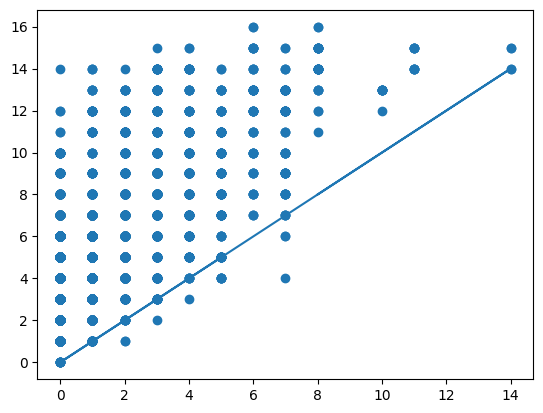

In [75]:
plt.scatter(TOTAL_a_target.values, TOTAL_PREDS)
plt.plot(TOTAL_a_target.values, TOTAL_a_target.values)